# Data Loading and EDA

This notebook loads and prepares the firewall log data from two different sources:
- `log2.csv`: real log data but missing timestamp
- `synthetic_log.csv`: generated log data with timestamps and additional features

We'll combine both, ensure structure consistency, and explore the merged dataset.

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
pd.set_option("display.max_columns", None)

##### Load `log2.csv` and inspect its structure

In [150]:
log2_path = DATA_DIR / "log2.csv"
df_log2 = pd.read_csv(log2_path)
print("Original log2 shape:", df_log2.shape)
df_log2.head()

Original log2 shape: (65532, 12)


,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [151]:
df_log2.info()
df_log2.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

##### 1. Generate synthetic firewall log data (Refer data_synthesis.py file for code)
##### 2. Combine both logs into a single unified dataset
##### 3. Preprocessing

In [152]:
syn_path = DATA_DIR / "synthetic_log.csv"
df_syn = pd.read_csv(syn_path)

print("Shape:", df_syn.shape)
df_syn.head()

Shape: (1000, 10)


,timestamp,src_ip,dst_ip,bytes_sent,bytes_received,action,application,url_category,user_id,total_traffic_byte
0,2025-07-01 00:00:00,10.0.22.197,172.16.223.16,31817,19867,allow,smtp,news,user339,51684
1,2025-07-01 01:00:00,10.0.166.112,172.16.101.117,84288,3484,allow,smtp,business,user218,87772
2,2025-07-01 02:00:00,10.0.110.219,172.16.203.33,3624,62768,allow,dns,adult,user520,66392
3,2025-07-01 03:00:00,10.0.21.178,172.16.110.39,44694,68333,allow,dns,news,user663,113027
4,2025-07-01 04:00:00,10.0.51.24,172.16.200.161,80115,77284,allow,unknown,adult,user262,157399


In [153]:
df_syn.info()
df_syn.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   timestamp           1000 non-null   object
 1   src_ip              1000 non-null   object
 2   dst_ip              1000 non-null   object
 3   bytes_sent          1000 non-null   int64 
 4   bytes_received      1000 non-null   int64 
 5   action              1000 non-null   object
 6   application         1000 non-null   object
 7   url_category        1000 non-null   object
 8   user_id             1000 non-null   object
 9   total_traffic_byte  1000 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 78.2+ KB


timestamp             0
src_ip                0
dst_ip                0
bytes_sent            0
bytes_received        0
action                0
application           0
url_category          0
user_id               0
total_traffic_byte    0
dtype: int64

In [154]:
df_log2.rename(columns={
    "source_ip": "src_ip",
    "destination_ip": "dst_ip",
    "bytes": "bytes_sent"
}, inplace=True)

In [155]:
for col in df_syn.columns:
    if col not in df_log2.columns:
        df_log2[col] = np.nan

In [156]:
df_log2 = df_log2[df_syn.columns]

In [157]:
df_log2["timestamp"] = pd.date_range(start="2025-07-01", periods=len(df_log2), freq="h")

In [158]:
df_all = pd.concat([df_log2, df_syn], ignore_index=True)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"], errors="coerce")
df_all["timestamp"] = df_all["timestamp"].dt.tz_localize(None)

In [159]:
df_all.to_csv(DATA_DIR / "combined_firewall.csv", index=False)
print("Combined shape:", df_all.shape)
df_all.head()

Combined shape: (66532, 10)


,timestamp,src_ip,dst_ip,bytes_sent,bytes_received,action,application,url_category,user_id,total_traffic_byte
0,2025-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Load the combined data

In [174]:
df = pd.read_csv("data/combined_firewall.csv", parse_dates=["timestamp"])
df["timestamp"] = df["timestamp"].dt.tz_localize(None)

In [166]:
df["bytes_sent"] = df["bytes_sent"].fillna(0)
df["bytes_received"] = df["bytes_received"].fillna(0)

In [175]:
if "total_traffic_bytes" not in df.columns:
    df["total_traffic_bytes"] = df["bytes_sent"] + df["bytes_received"]

print("Shape:", df.shape)
display(df.tail(5))
df.info()
display(df.isna().sum())
print("\nAction counts:\n", df["action"].value_counts(dropna=False))

Shape: (66532, 11)


,timestamp,src_ip,dst_ip,bytes_sent,bytes_received,action,application,url_category,user_id,total_traffic_byte,total_traffic_bytes
66527,2025-08-11 11:00:00,10.0.135.112,172.16.192.192,21252.0,21087.0,allow,ftp,news,user306,42339.0,42339.0
66528,2025-08-11 12:00:00,10.0.73.163,172.16.35.73,74696.0,85451.0,allow,ssl,unknown,user228,160147.0,160147.0
66529,2025-08-11 13:00:00,10.0.192.1,172.16.130.86,81963.0,97926.0,allow,snmp,news,user24,179889.0,179889.0
66530,2025-08-11 14:00:00,10.0.140.253,172.16.6.215,67884.0,75313.0,allow,web-browsing,malware,user553,143197.0,143197.0
66531,2025-08-11 15:00:00,10.0.71.72,172.16.186.133,49910.0,9898.0,allow,snmp,malware,user255,59808.0,59808.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66532 entries, 0 to 66531
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            66532 non-null  datetime64[ns]
 1   src_ip               1000 non-null   object        
 2   dst_ip               1000 non-null   object        
 3   bytes_sent           1000 non-null   float64       
 4   bytes_received       1000 non-null   float64       
 5   action               1000 non-null   object        
 6   application          1000 non-null   object        
 7   url_category         1000 non-null   object        
 8   user_id              1000 non-null   object        
 9   total_traffic_byte   1000 non-null   float64       
 10  total_traffic_bytes  1000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 5.6+ MB


timestamp                  0
src_ip                 65532
dst_ip                 65532
bytes_sent             65532
bytes_received         65532
action                 65532
application            65532
url_category           65532
user_id                65532
total_traffic_byte     65532
total_traffic_bytes    65532
dtype: int64


Action counts:
 action
NaN      65532
allow      849
deny       101
drop        50
Name: count, dtype: int64


In [176]:
print(df['action'].value_counts(dropna=False))

action
NaN      65532
allow      849
deny       101
drop        50
Name: count, dtype: int64


##### Plot event count per hour to understand the streaming

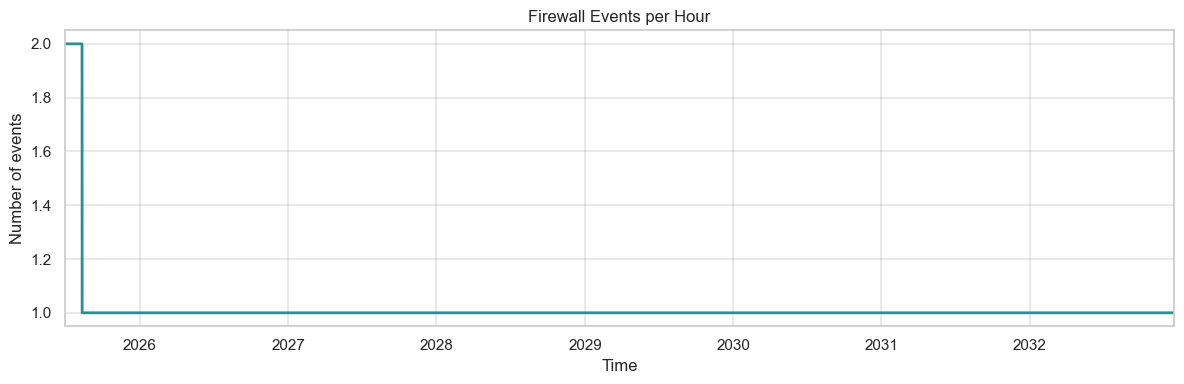

In [181]:
df["hour"] = df["timestamp"].dt.floor("h")
events_per_hour = df.set_index("timestamp").resample("1h").size()

plt.figure(figsize=(12, 4))
events_per_hour.plot(color="#298f91", linewidth=2)
plt.title("Firewall Events per Hour")
plt.ylabel("Number of events")
plt.xlabel("Time")
plt.tight_layout()
plt.show()

##### Understanding the data  sent and  received

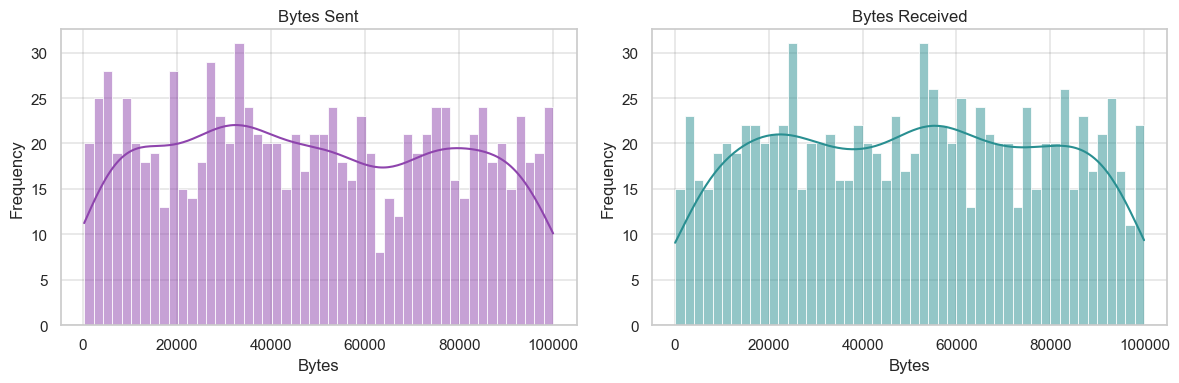

In [183]:
color_sent = "#8e44ad"
color_received = "#298f91"

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(
    df["bytes_sent"],
    bins=50,
    ax=axes[0],
    kde=True,
    color=color_sent
)
axes[0].set_title("Bytes Sent", fontsize=12)
axes[0].set_xlabel("Bytes")
axes[0].set_ylabel("Frequency")

sns.histplot(
    df["bytes_received"],
    bins=50,
    ax=axes[1],
    kde=True,
    color=color_received
)
axes[1].set_title("Bytes Received", fontsize=12)
axes[1].set_xlabel("Bytes")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

##### Top 10 ip's are active

In [179]:
print("\nTop 10 Source IPs by count:")
display(df["src_ip"].value_counts().head(10))


Top 10 Source IPs by count:


src_ip
10.0.60.10      2
10.0.112.239    2
10.0.209.15     2
10.0.51.24      1
10.0.95.141     1
10.0.42.193     1
10.0.213.39     1
10.0.94.120     1
10.0.110.219    1
10.0.187.194    1
Name: count, dtype: int64

### Time-series event plot

I could see a uniform distribution of events over time, but some spikes that may represent bursts or scheduled jobs.

### Top Source IPs

We looked at which source IP addresses showed up the most in the logs.

The top 10 IPs only appeared 1 or 2 times each.  
This means the traffic is pretty evenly spread out, and no single IP is making lots of requests.

So, at this point, we don’t see any source IP behaving in a suspicious or unusual way just based on how often they appear.



#### Application Distribution

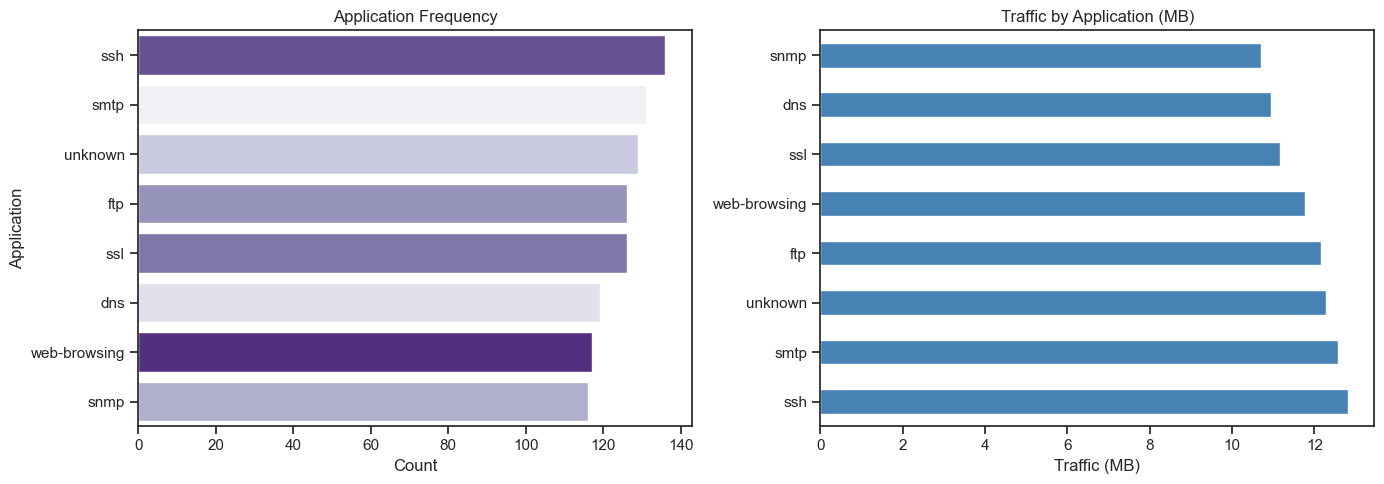

In [ ]:
app_counts = df["application"].value_counts()
app_traffic = (
    df.groupby("application")["total_traffic_bytes"]
      .sum()
      .sort_values(ascending=False) / (1024**2)
)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(
    y="application",
    data=df,
    order=app_counts.index,
    palette="Purples",
    hue="application",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Application Frequency")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Application")

app_traffic.plot(
    kind="barh",
    color="steelblue",
    ax=axes[1]
)
axes[1].set_title("Traffic by Application (MB)")
axes[1].set_xlabel("Traffic (MB)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

#### Traffic by URL category 

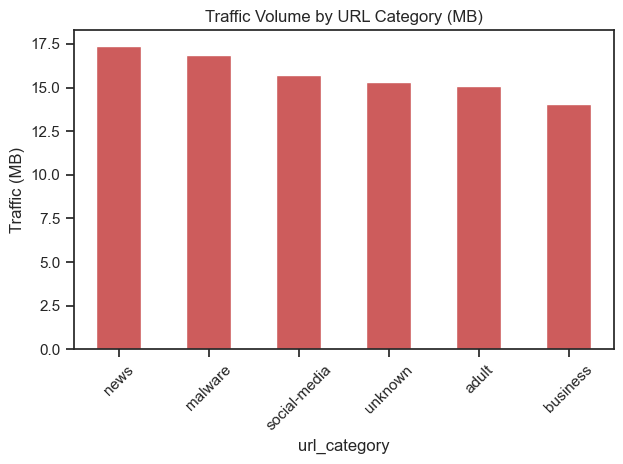

In [ ]:
cat_traffic = (
    df.groupby("url_category")["total_traffic_bytes"]
      .sum()
      .sort_values(ascending=False) / (1024**2)
)

cat_traffic.plot(kind="bar", color="indianred")
plt.title("Traffic Volume by URL Category (MB)")
plt.ylabel("Traffic (MB)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Top source IPs by traffic
#### Top destination IPs by traffic

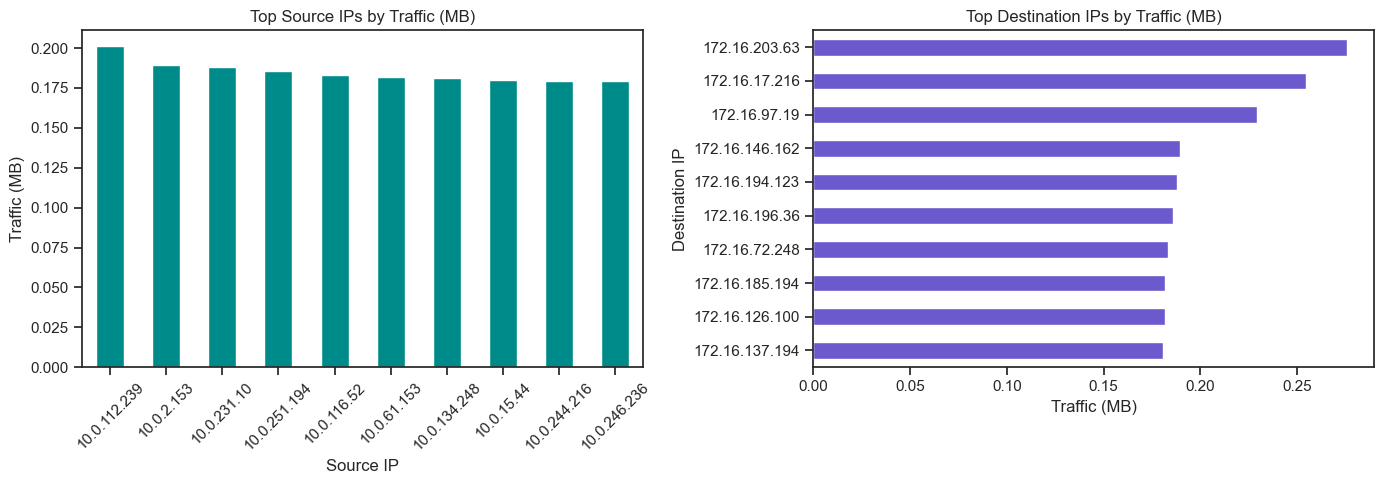

In [210]:
src_top = (
    df.groupby("src_ip")["total_traffic_bytes"]
      .sum()
      .sort_values(ascending=False)
      .head(10) / (1024**2)
)

dst_top = (
    df.groupby("dst_ip")["total_traffic_bytes"]
      .sum()
      .sort_values(ascending=False)
      .head(10) / (1024**2)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

src_top.plot(
    kind="bar",
    color="darkcyan",
    ax=axes[0]
)
axes[0].set_title("Top Source IPs by Traffic (MB)")
axes[0].set_ylabel("Traffic (MB)")
axes[0].set_xlabel("Source IP")
axes[0].tick_params(axis='x', rotation=45)

dst_top.sort_values().plot(
    kind="barh",
    color="slateblue",
    ax=axes[1]
)
axes[1].set_title("Top Destination IPs by Traffic (MB)")
axes[1].set_xlabel("Traffic (MB)")
axes[1].set_ylabel("Destination IP")

plt.tight_layout()
plt.show()

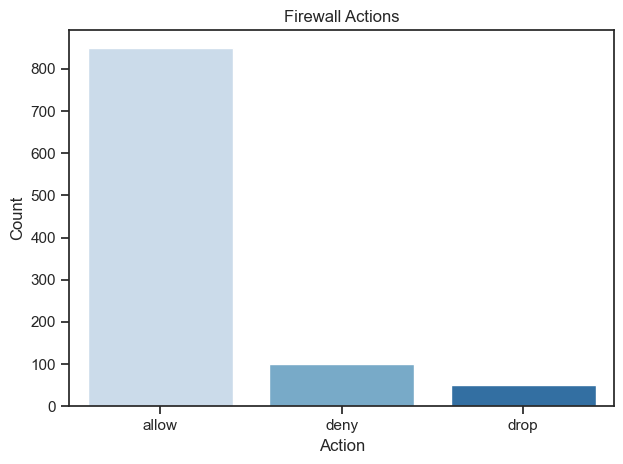

In [211]:
sns.countplot(
    x="action",
    data=df,
    palette="Blues",
    hue="action",
    legend=False
)
plt.title("Firewall Actions")
plt.xlabel("Action")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


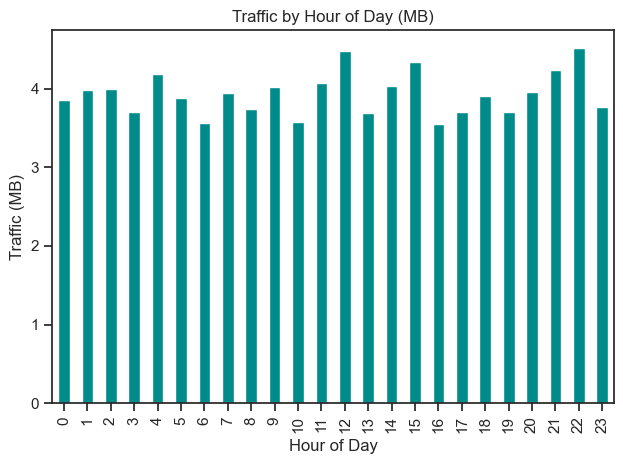

In [ ]:
df["hour_of_day"] = df["timestamp"].dt.hour
hourly_mb = (
    df.groupby("hour_of_day")["total_traffic_bytes"]
      .sum() / (1024**2)                          
)

hourly_mb.plot(kind="bar", color="darkcyan")
plt.title("Traffic by Hour of Day (MB)")
plt.ylabel("Traffic (MB)")
plt.xlabel("Hour of Day")
plt.tight_layout()
plt.show()